In [1]:
#import necessary modules

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.17.0


# Datasetteki bir kaç resmi outputla

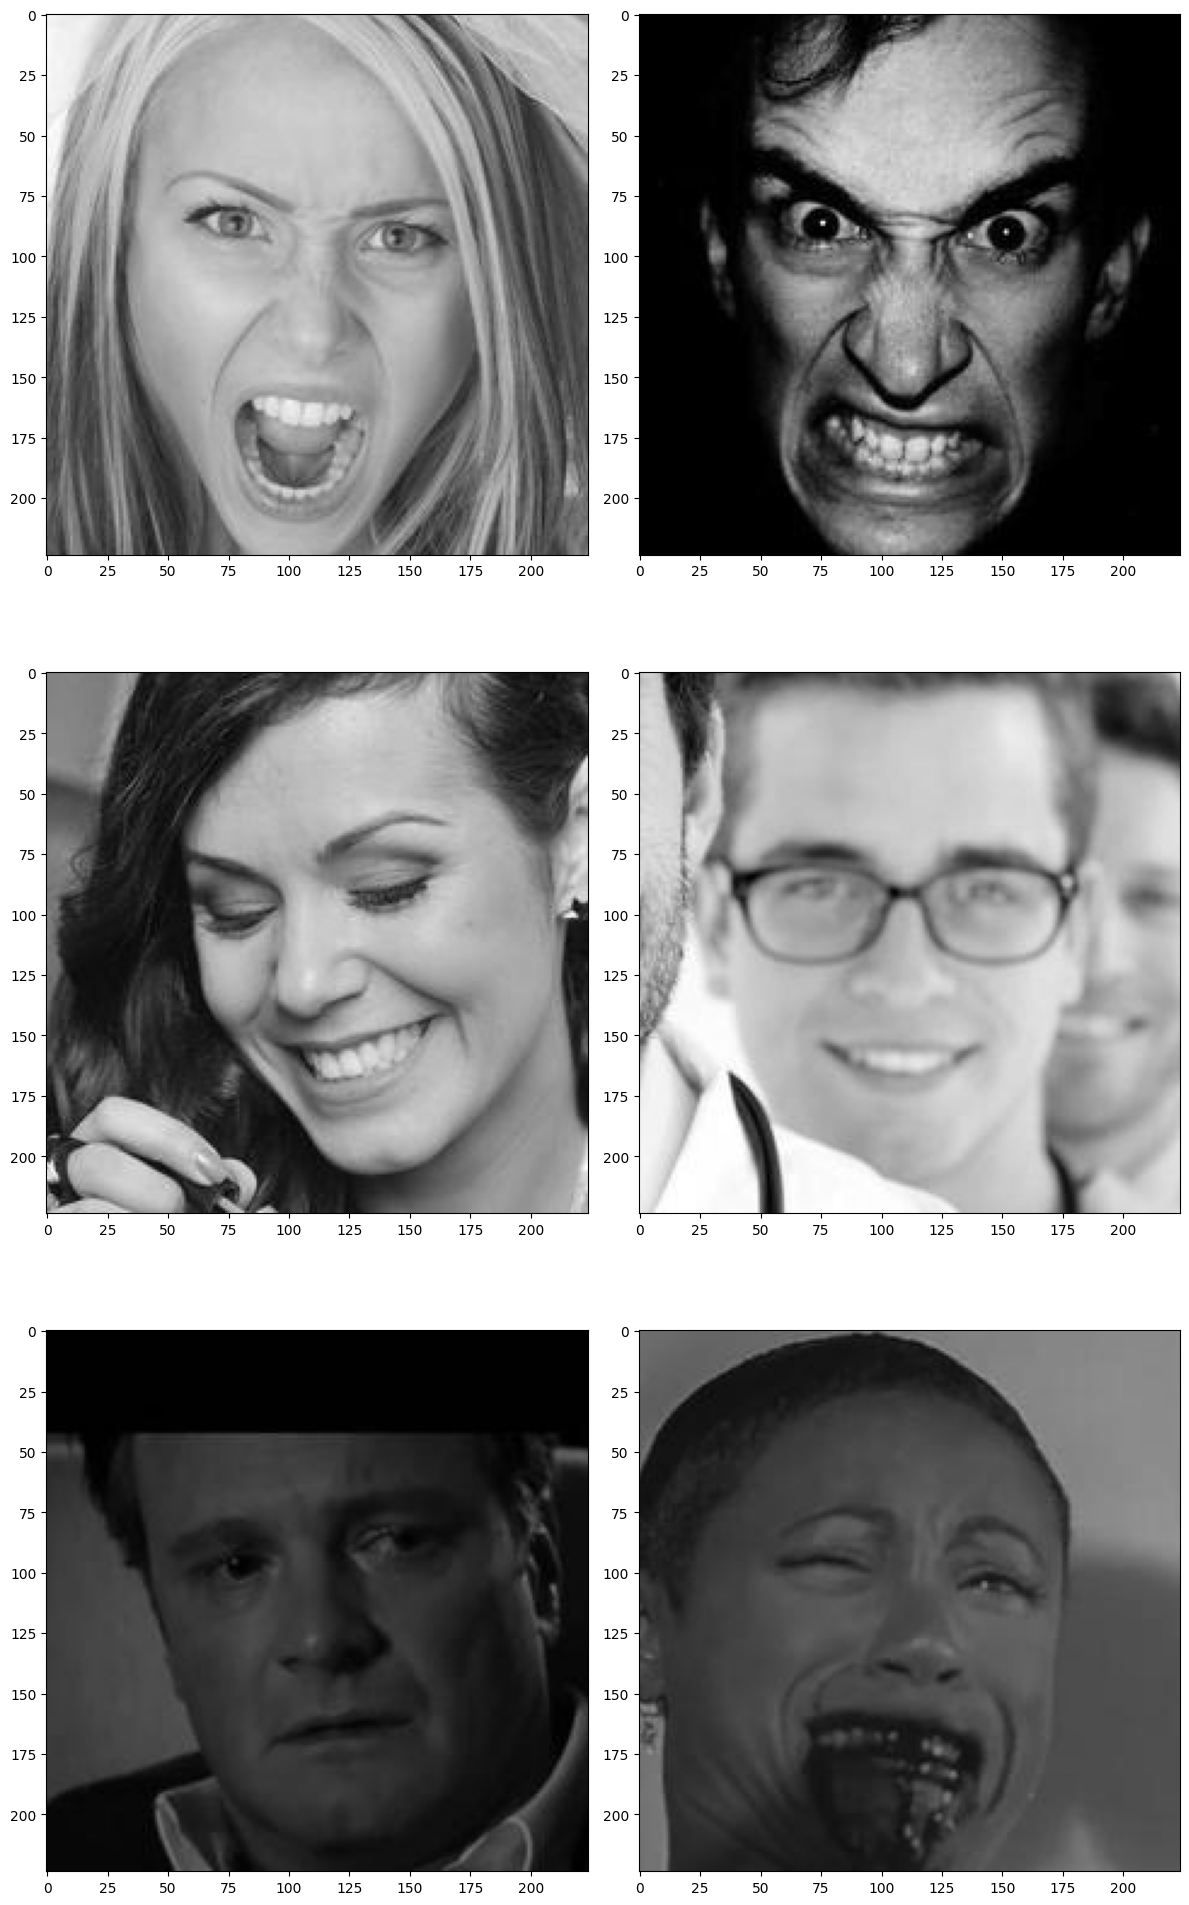

In [3]:

img_size = 224
plt.figure(0, figsize=(12,20))
ctr = 0

for expression in os.listdir("datasett/dataset1/train"):
    for i in range(1,3):
        ctr += 1
        plt.subplot(3,2,ctr)
        img = load_img("datasett/dataset1/train/" + expression + "/" +os.listdir("datasett/dataset1/train/" + expression)[i], target_size=(img_size, img_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [4]:
#Tüm duygu klasörlerini ve countlarını printle, Test klasörüne de ulaşabilirsin
for expression in os.listdir("datasett/dataset1/train/"):
    print(str(len(os.listdir("datasett/dataset1/train/" + expression))) + " " + expression + " images")

3612 Angry images
6510 Happy images
6183 Sad images


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

# ImageDataGeneratorsları başlat training ve test için
datagen_train = ImageDataGenerator(rescale=1./255)
datagen_validation = ImageDataGenerator(rescale=1./255)

# Train ve Test generatorları oluştur
train_generator = datagen_train.flow_from_directory(
    'datasett/dataset1/train',
    target_size=(img_size, img_size),
    color_mode='grayscale',  # resimler b&W olduğu için
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen_validation.flow_from_directory(
    'datasett/dataset1/test',
    target_size=(img_size, img_size),
    color_mode='grayscale',  # resimler b&W olduğu için
    batch_size=batch_size,
    class_mode='categorical'
)

Found 16305 images belonging to 3 classes.
Found 4622 images belonging to 3 classes.


# Build CNN model:

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D

# input shapeı belirle (widht, hight, colorScale)
input_shape = (img_size, img_size, 1)

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # mobilenetden çekilen Base Modeli tut

model = Sequential([
    Input(shape=(img_size, img_size, 3)),  # Input layer (b&W resimler için...)
    tf.keras.layers.Conv2D(3, (3, 3), padding='same'),  # Model içinde grayscale resimleri RGB ye dönüştürüyor # Nedden??
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

epochs = 30  # epoch sayısı arttırılabilir
initial_learning_rate = 0.0001

opt = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.build((None, img_size, img_size, 3))  # Manuel olarak ayağa kaldır, ama colorScalı 3 #Nedden??
#---------------------------------------------------------------
# for batch in train_generator:
#     print(batch[0].shape)  # print (batch_size, 224, 224, 3) olmalı
#     break


# input shape ı tanımlamak için modeli batch datasıyla çağır
sample_batch = train_generator[0][0]
_ = model(sample_batch) # BU KISIM ÇALIŞMADI...

# Debug Layerın Output shapini ayarla
debug_model = Model(inputs=model.input, outputs=[layer.output for layer in model.layers])
debug_shapes = debug_model.predict(sample_batch)  # batch ve tahmini al

for layer, shape in zip(model.layers, debug_shapes):
    print(f"Layer: {layer.name}, Output shape: {shape.shape}")
    
#---------------------------------------------------------------


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d_2" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 224, 224, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224, 224, 1), dtype=float32)
  • training=None
  • mask=None

In [ ]:
# CNNi başlat
model = Sequential()

# 1 - Convolution
model.add(Conv2D(32,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(128,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='softmax'))

epochs = 30 
initial_learning_rate = 0.001

opt = Adam(learning_rate=initial_learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\burci\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

ValueError: Undefined shapes are not supported.

# Train and Evaluate the model:

In [13]:
from sklearn.utils.class_weight import compute_class_weight

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

#Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-6, mode='auto')

# Model checkpoint
checkpoint = ModelCheckpoint("modelll_weight.keras", monitor='val_accuracy',
                             mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

#-----------------------
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=initial_learning_rate / 10), loss='categorical_crossentropy', metrics=['accuracy'])
#-----------------------

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Class weights: {0: 2.0603543743078627, 1: 0.6603371783496007, 2: 0.9997313272434175}


ValueError: The layer sequential has never been called and thus has no defined input.

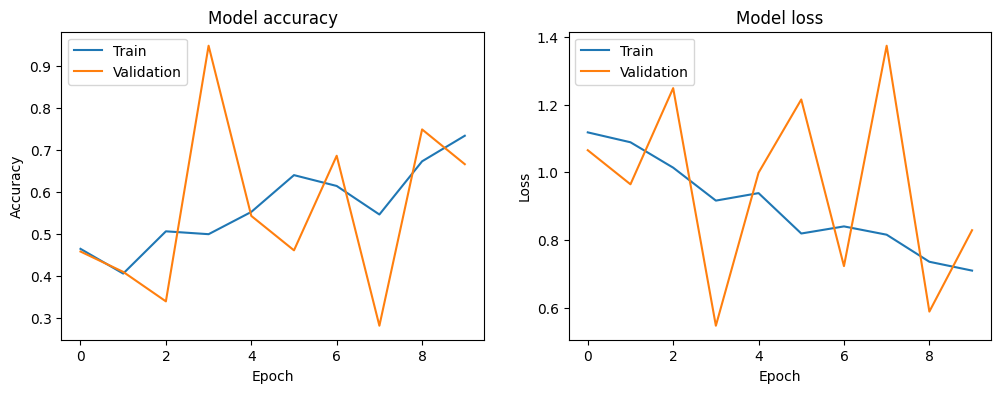

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Represent model in .json format for future loading :

In [1]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\burci\AppData\Local\Temp\ipykernel_10696\158931365.py:2: SyntaxWarning: invalid escape sequence '\m'
  with open("new_model\model_architecture.json", "w") as json_file:
C:\Users\burci\AppData\Local\Temp\ipykernel_10696\158931365.py:2: SyntaxWarning: invalid escape sequence '\m'
  with open("new_model\model_architecture.json", "w") as json_file:


NameError: name 'model' is not defined

In [1]:
import tensorflow as tf

model = tf.keras.models.load_model('new_model/trained_emotion_model2.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\burci\AppData\Local\Temp\tmpmlvwn05g\assets


INFO:tensorflow:Assets written to: C:\Users\burci\AppData\Local\Temp\tmpmlvwn05g\assets


Saved artifact at 'C:\Users\burci\AppData\Local\Temp\tmpmlvwn05g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2422605284368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605285712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605283984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605286672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605287824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605288592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605288784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605289744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605289936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2422605290704: TensorSpec(shape=(), dtype=tf.resource, name=None)
